<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [1]:
from IPython.display import HTML

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score # this was used in "fit_model" def
from sklearn.model_selection import GridSearchCV

from sklearn import set_config
from sklearn.tree import DecisionTreeClassifier

In [3]:
from sklearn.datasets import load_boston

boston = load_boston()

#Instead of reading data into a single dataframe put training/testing data into X and the answer (For testing) in y_raw:
X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)

# I changed to 'y_raw' because this dataframe format did not work in my future cells.  I created a 'y' series later.
y_raw = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
#Create a dataframe (df) with all values including the final price just for EDA phase.
#Xy = [X,y]
df = pd.concat([X, y_raw], axis=1, sort=False)

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [6]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

#df.head()
#df.shape #506 rows 14 columns total; 13 in X 1 in y
#df.info() #all columns have data in 506 rows, no nulls, and all float64
df.describe() #no oddities such as negative numbers or lots of zeroes or super high numbers.
#df['TAX'].value_counts(bins=5) #look at some averages
#df.mean() #averages for all columns

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [5]:
# visual check for correlations.  There are lots of them!

df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


In [94]:
# some additional EDA

#df['CHAS'].value_counts() # want to make sure this column is just zeroes and ones
#df['ZN'].value_counts().sort_index()
#df['RAD'].value_counts() # majority of houses are either right next to a freeway or furthest from it.
#df['PTRATIO'].value_counts().sort_index() # as expected the greatest number of houses are in an area with a high PTRATIO
df['MEDV']

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

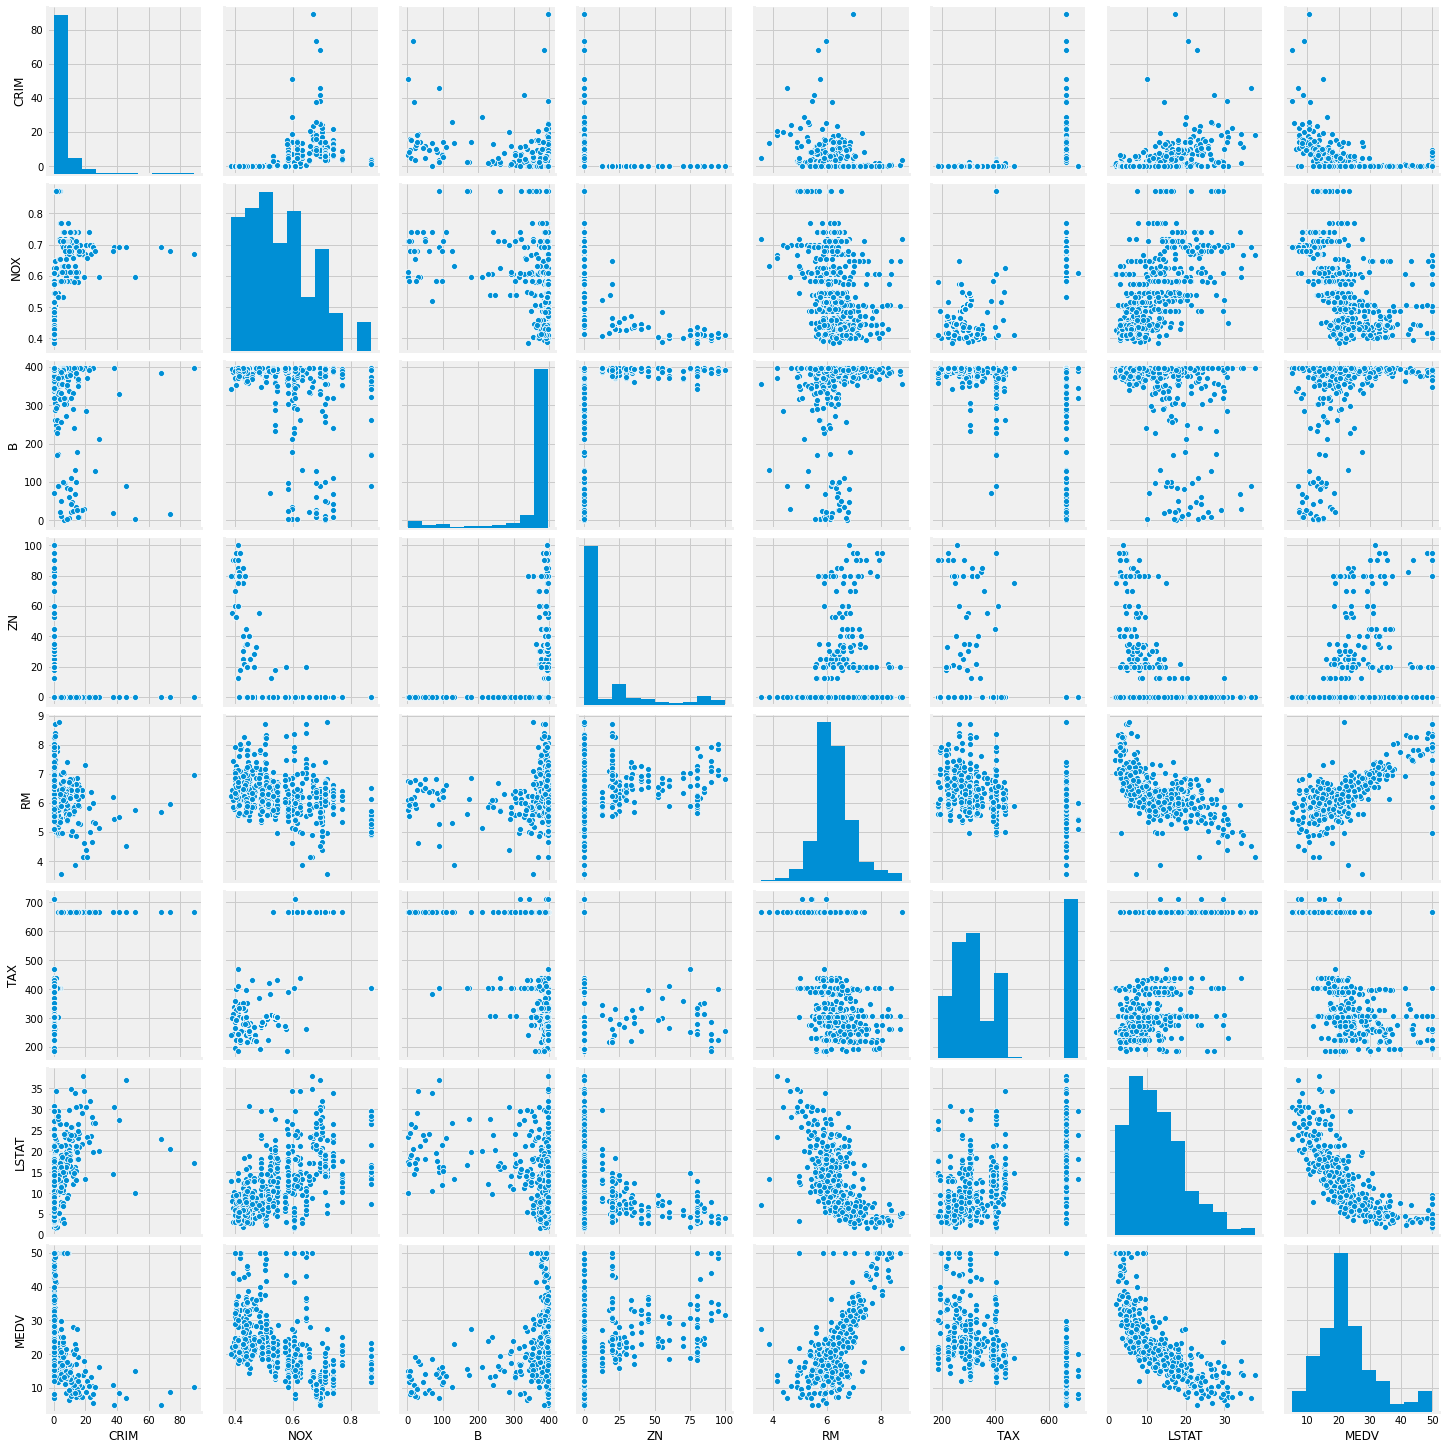

In [6]:
# too many columns to run pairplot over the whole thing, so was doing a few columns at a time.
# I realize that would mean I'm not seeing all correlations.
# CHAS, AGE, PTRATIO, and most columns do not have much relationship.
# RM has the biggest.  Other good indicators are B, ZN, LSTAT, NOX, CRIM, TAX

sns.pairplot(
    df,
    x_vars=["CRIM", "NOX", "B", "ZN", "RM", "TAX", "LSTAT", "MEDV"],
    y_vars=["CRIM", "NOX", "B", "ZN", "RM", "TAX", "LSTAT", "MEDV"],
);

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [8]:
# RM, LSTAT, NOX, CRIM have the most correlation based on an ocular patdown of the pairplot above.
# B, ZN, TAX are second best

# I used those columns as my predictors (aka selects)

X_select_a = X[['RM', 'LSTAT', 'NOX', 'CRIM']]
X_select_b = X[['B', 'ZN','TAX']]
X_select_c = X[['RM', 'CHAS','RAD', 'ZN']] # I came up with this after checking the coefficnet of ALL columns a few cells below
y = df['MEDV']

In [9]:
# TEST my initial selects, all columns, and then added a third select based on coefficients resuls.

# instantiate
lm_a = LinearRegression() # A selects
lm_b = LinearRegression() # B selects
lm_all = LinearRegression() # all columns
lm_c = LinearRegression() # this "c" select came out of looking at the coefficients of lm_all and using the best columns


# fit   #X is the columns and y is what you want to predict.
lm_a.fit(X_select_a, y)
lm_b.fit(X_select_b, y)
lm_all.fit(X, y)
lm_c.fit(X_select_c, y)

# predict
a_preds = lm_a.predict(X_select_a)
b_preds = lm_b.predict(X_select_b)
all_preds = lm_all.predict(X)
c_preds = lm_c.predict(X_select_c)

In [10]:
# r2 score   # this will compare the predictions against the actual price.  scale of -1 to 1
print ("a_preds r2:", r2_score(a_preds, y), '\n'
       "b_preds r2:", r2_score(b_preds, y), '\n'
       "all_preds r2:", r2_score(all_preds, y),  '\n'
       "c_preds r2:", r2_score(c_preds, y))

# ALL columns did better than either of my selections.  I thought "c" would do better than my "a" selects because they had
# the highest coeffient from the "all" results, but my "a" selects, based on visually scanning the pairplot was better.
# why is b negative?

a_preds r2: 0.45166130183642694 
b_preds r2: -1.4820723912689844 
all_preds r2: 0.6498212316698544 
c_preds r2: 0.22931427745225375


In [8]:
# square root score
# lower number better.  Less MSE the more efficient your model because it's centered around the average
print("a_preds sqrt:", np.sqrt(mean_squared_error(a_preds, y)), '\n'
      "b_preds sqrt:", np.sqrt(mean_squared_error(b_preds, y)), '\n'
      "all_preds sqrt:", np.sqrt(mean_squared_error(all_preds, y)), '\n'
      "c_preds sqrt:", np.sqrt(mean_squared_error(c_preds, y)))

# As with r2 all columns is best followed by A select, C select, and then B.

a_preds sqrt: 5.467804730100967 
b_preds sqrt: 7.757286941968887 
all_preds sqrt: 4.679191295697282 
c_preds sqrt: 6.061630315348566


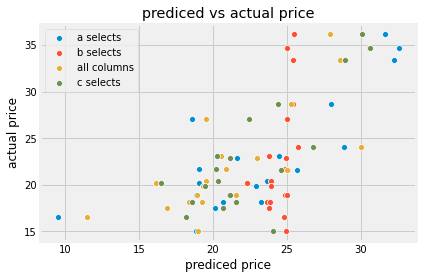

In [10]:
# plot selects based on prediced and actual price

# A select
sns.scatterplot(lm_a.predict(X_select_a.head(20)), y[:20], label='a selects');
#sns.scatterplot(lm_a.predict(X_select_a.tail(10)), y[-10:]);

# B select
sns.scatterplot(lm_b.predict(X_select_b.head(20)), y[:20], label='b selects');

# ALL columns
sns.scatterplot(lm_all.predict(X.head(20)), y[:20], label='all columns');

# C selects
sns.scatterplot(lm_c.predict(X_select_c.head(20)), y[:20], label='c selects');

plt.title('prediced vs actual price')
plt.xlabel('prediced price');
plt.ylabel('actual price');
plt.legend();

# "b" selects are really weird with all their preds being right around 25k.

In [11]:
# I wanted to see the coefficient values for my select columns and all columns
# when I combined all of these into one cell it did weird things to the coef and the scatterplots above.
# This is what drove the creation of my 'selects_c' df above.

print("A SELECTS:")
for col_a, coef_a in zip(X_select_a.columns, lm_a.coef_):
    print(col_a, "COEF:", coef_a)
print("INTERCEPT:", lm_a.intercept_, '\n')

print("B SELECTS:")
for col_b, coef_b in zip(X_select_b.columns, lm_b.coef_):
    print(col_b, "COEF:", coef_b)
print("INTERCEPT:", lm_a.intercept_, '\n')

print("ALL SELECTS:")
for col_all, coef_all in zip(X.columns, lm_all.coef_):
    print(col_all, "COEF:", coef_all)
print("INTERCEPT:", lm_a.intercept_)

A SELECTS:
RM COEF: 5.218551412043494
LSTAT COEF: -0.5773837017991812
NOX COEF: -0.12239498723604256
CRIM COEF: -0.10263505366514655
INTERCEPT: -2.5194427600052123 

B SELECTS:
B COEF: 0.014774796104001245
ZN COEF: 0.09090081495713465
TAX COEF: -0.01807525644515781
INTERCEPT: -2.5194427600052123 

ALL SELECTS:
CRIM COEF: -0.10801135783679787
ZN COEF: 0.04642045836688227
INDUS COEF: 0.020558626367068095
CHAS COEF: 2.6867338193448576
NOX COEF: -17.766611228299894
RM COEF: 3.8098652068092127
AGE COEF: 0.0006922246403441657
DIS COEF: -1.4755668456002577
RAD COEF: 0.3060494789851771
TAX COEF: -0.012334593916574633
PTRATIO COEF: -0.9527472317072887
B COEF: 0.009311683273793649
LSTAT COEF: -0.5247583778554881
INTERCEPT: -2.5194427600052123


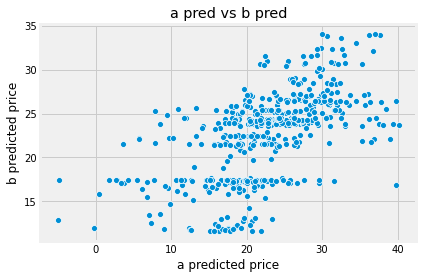

In [12]:
# see how model a corresponds to model b
sns.scatterplot(a_preds, b_preds)

plt.title('a pred vs b pred')
plt.xlabel('a predicted price');
plt.ylabel('b predicted price');

# "a" selects have a greater range of estimates going over 35 (which is good) and under 0 (which is not good)

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [11]:
# Create train/test splits.
X_train_70, X_test_70, y_train_70, y_test_70 = train_test_split(X, y, test_size=0.30, random_state=42)
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(X, y, test_size=0.20, random_state=42)
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=42)

In [12]:
# verify the splits
print(X.shape, X.shape, len(y), len(y))
print(X_train_70.shape, X_test_70.shape, len(y_train_70), len(y_test_70))
print(X_train_80.shape, X_test_80.shape, len(y_train_80), len(y_test_80))
print(X_train_90.shape, X_test_90.shape, len(y_train_90), len(y_test_90))
print(X_train.shape, X_test.shape, len(y_train), len(y_test))

(506, 13) (506, 13) 506 506
(354, 13) (152, 13) 354 152
(404, 13) (102, 13) 404 102
(455, 13) (51, 13) 455 51
(505, 13) (1, 13) 505 1


In [15]:
# setup the model

#instantiate
lm_70 = LinearRegression()
lm_90 = LinearRegression()

#fit
lm_70.fit(X_train_70, y_train_70)
lm_90.fit(X_train_90, y_train_90)

#predict
lm_preds_70 = lm_70.predict(X_test_70)
lm_preds_90 = lm_90.predict(X_test_90)

In [16]:
# r2 score this will compare the predictions against the actual price.  scale of -1 to 1

print("lm 70 r2 score:",r2_score(lm_preds_70, y_test_70),'\n'
      "lm 90 r2 score:",r2_score(lm_preds_90, y_test_90))

# Using a 90% split scored better

lm 70 r2 score: 0.6693702691495602 
lm 90 r2 score: 0.7545683007337224


In [17]:
# square root error (MSRE)
# lower number better.  Less MSE the more efficient your model because it's centered around the average

print('lm 70 sqrt score: {}'.format(np.sqrt(mean_squared_error(y_test_70, lm_preds_70))))
print('lm 90 sqrt score: {}'.format(np.sqrt(mean_squared_error(y_test_90, lm_preds_90))))

# Using a 90% split scored better

lm 70 sqrt score: 4.638689926172839
lm 90 sqrt score: 3.8724479178657587


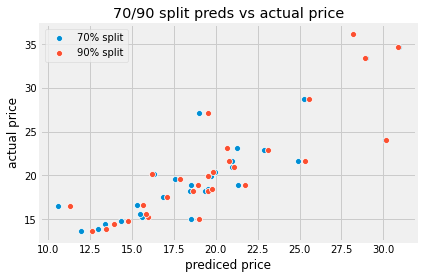

In [18]:
# plot the 70 and 90 percent

sns.scatterplot(lm_70.predict(X.head(30)), y[:30], label='70% split');
sns.scatterplot(lm_90.predict(X.head(30)), y[:30], label='90% split');

plt.title('70/90 split preds vs actual price')
plt.xlabel('prediced price');
plt.ylabel('actual price');
plt.legend();

# you can see how 90% is just a touch better for almost each house
# interestingly for the expensive houses (>30) 70 and 90 matched identically.  I had to turn off the 90% map to see the 70% markers in this range

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [19]:
# KNN model
# check which number of neighbors work best.
# the best "k" comes from test data NOT training data

scores_70 = []
scores_90 = []
neighbors = []

for n in range(1, 10):
    #instantiate
    knn_70 = KNeighborsRegressor(n)
    knn_90 = KNeighborsRegressor(n)
    
    #fit
    knn_70.fit(X_train_70, y_train_70)
    knn_90.fit(X_train_90, y_train_90)
    
    #predict
    knn_preds_70 = knn_70.predict(X_test_70)
    knn_preds_90 = knn_90.predict(X_test_90)
    
    #score
    score_70 = np.sqrt(mean_squared_error(y_test_70, knn_preds_70))
    score_90 = np.sqrt(mean_squared_error(y_test_90, knn_preds_90))
    
    neighbors.append(n)
    scores_70.append(score_70)
    scores_90.append(score_90)

print ('70 / 30 split:')
for n, score_70 in zip(neighbors, scores_70):
    print("knn score for",n,"neighbor(s):", score_70)

print('90 / 10 split:')

for n, score_90 in zip(neighbors, scores_90):
    print("knn score for",n,"neighbor(s):", score_90)
    
# interesting.  for the 70/30 split 3 neighbors was best, but for the 90/10 split 6 neighbors was best.

70 / 30 split:
knn score for 1 neighbor(s): 6.194877977643687
knn score for 2 neighbor(s): 5.82438866229527
knn score for 3 neighbor(s): 5.305594669339303
knn score for 4 neighbor(s): 5.419213807322394
knn score for 5 neighbor(s): 5.562872222909767
knn score for 6 neighbor(s): 5.798231007957291
knn score for 7 neighbor(s): 5.902172859914698
knn score for 8 neighbor(s): 6.004740195117127
knn score for 9 neighbor(s): 6.173004158785208
90 / 10 split:
knn score for 1 neighbor(s): 7.544807330015713
knn score for 2 neighbor(s): 6.9060856936359505
knn score for 3 neighbor(s): 5.6091156744390185
knn score for 4 neighbor(s): 5.347231049988469
knn score for 5 neighbor(s): 5.285082224303332
knn score for 6 neighbor(s): 4.989446378447081
knn score for 7 neighbor(s): 5.141993780627901
knn score for 8 neighbor(s): 5.328061982118274
knn score for 9 neighbor(s): 5.573588597768715


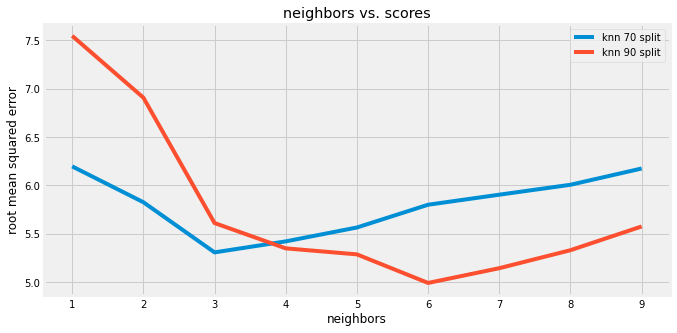

In [20]:
# plot out what we found above.

plt.figure(figsize=(10, 5));
plt.plot(neighbors, scores_70, label='knn 70 split');
plt.plot(neighbors, scores_90, label='knn 90 split');
plt.xlabel('neighbors');
plt.ylabel('root mean squared error');
plt.title('neighbors vs. scores');
plt.legend();

# same info as above, but easy to see where the best neighbor value is for each split

In [20]:
# GRID SEARCHING
# Just to try it out I'm throwing a grid search at the housing data.

# this ensures the full output from GridSearch
set_config(print_changed_only=False)

# dictionary to hold each hyper parameter and the values to use.  max_features; auto, sqrt, log2 are used below, but
# this dictionary of paramters could be as big as you want (that is any available hyper parameter)
# here are all the combinations I want grid search to to try. For example: 200, auto, 4, mse THEN 200, sqrt, 4, mse, etc...
# at the end it will return the model that did the best
param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4,8],
    'criterion':['mse', 'mae'] # could not use gini and entropy as it's a regression model
}

# instatiate the random forest classifier (rf)
rf = RandomForestRegressor()

# cross fold (cv) like a kfold.  Train on four folds and test on one (4+1=5)
# run through all options outlined in the param_grid above
# we are doing the same steps of an instantied model where we fit, predict, and score
cv_rf = GridSearchCV(rf, param_grid=param_grid, cv= 5)
cv_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [21]:
cv_rf.best_estimator_

# Best parameters are: mse, depth of 8, auto features, and 500 n estimators

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [39]:
cv_rf.best_score_

0.8718700949868132

# KNN Practice

In [49]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [50]:
# Increase the default figure and font sizes for easier viewing

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [51]:
# Create a custom colormap

from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [ ]:
# Map each iris species to a number

# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'
# iris.species.unique() confirm the three species

# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES

# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES

In [52]:
# create the column
iris['species_num'] = ""

In [53]:
# populate the 'species_num' column with 0, 1, or 2 based on species value
conditions = [
    (iris['species'] == 'Iris-setosa'),
    (iris['species'] == 'Iris-versicolor'),
    (iris['species'] == 'Iris-virginica'),]
choices = ['0', '1', '2']
iris['species_num'] = np.select(conditions, choices)

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [54]:
# Assign four columns for predicting to X
X_iris = iris.iloc[:,0:4]

# have a look at the data to get a feel for it
X_iris.head(5)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Create your target vector "y"
This will be the species type.

In [55]:
# assign 'species_num' to y
y_iris = iris['species_num']

# have a look at the data to get a feel for it
y_iris.head(5)

0    0
1    0
2    0
3    0
4    0
Name: species_num, dtype: object

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [56]:
# split the data into train / test splits
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris, y_iris, test_size=0.20, random_state=42)

In [57]:
# check it

print(X_iris_train.shape, X_iris_test.shape, y_iris_train.shape, y_iris_test.shape)

(120, 4) (30, 4) (120,) (30,)


### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [ ]:
# import happened already

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [58]:
#instantiate
knn = KNeighborsClassifier(1)

#fit
knn.fit(X_iris_train, y_iris_train)

#predict
iris_preds = knn.predict(X_iris_test)

#score
iris_accuracy = accuracy_score(iris_preds, y_iris_test)
iris_scored = knn.score(X_iris_test, y_iris_test)

In [59]:
iris_accuracy
#iris_score

# both accuracy and score are 1.
# These surprised me because this implies the model is 100% perfect!?

1.0

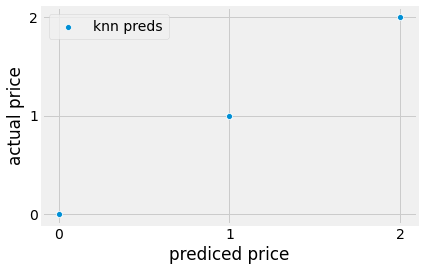

In [30]:
# i wanted to plot the model to see if I could figure out why the accuracy was 1
sns.scatterplot(knn.predict(X_iris), y_iris, label='knn preds');

plt.xlabel('prediced price');
plt.ylabel('actual price');

plt.legend();

# I should have known the plot wouldn't provide much because if the accuracy is 1 and the preds are just looking for
# one of three points (0, 1, 2) then the plot would be just those three points
# Did I overfit?

In [157]:
# I decided to try a linear regression to see how well that did

#instantiate
lm_iris = LinearRegression()

#fit
lm_iris.fit(X_iris, y_iris)

#predict
lm_iris_preds = lm_iris.predict(X_iris)

#score
lm_iris_sqrt_score = np.sqrt(mean_squared_error(lm_iris_preds, y_iris))
lm_iris_r2_score = r2_score(lm_iris_preds, y_iris)

lm_iris_sqrt_score
#lm_iris_r2_score

# It was also very good, but not perfect like KNN.

0.21537197661540586

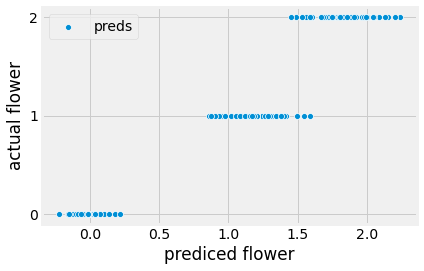

In [45]:
# Let's see where the preds fall on a plot

sns.scatterplot(lm_iris.predict(X_iris), y_iris, label='preds');

plt.xlabel('prediced flower');
plt.ylabel('actual flower');
plt.legend();

# Even though the preds do range outside the actual they barely overlap with the other preds, so that tells me why
# the score is so good.

In [163]:
# I wanted to look at our sample columns and see if I could find a reason why my preds are so good.
# I took an average of the columns to see how close they were

#pd.set_option('display.max_rows', 10)
print(iris.groupby("species")["sepal_length"].mean(),'\n')
print(iris.groupby("species")["sepal_width"].mean(),'\n')
print(iris.groupby("species")["petal_length"].mean(),'\n')
print(iris.groupby("species")["petal_width"].mean())

# What this tells me is there is very good separation in the species values (sepal_length, sepal_width, etc...)
# There is no overlap in the means.  Each one is separated by almost a full one point (eg 5.006 -> 5.936).
# If I'm understanding right this is why my preds are so successfu.
# It's because the data is highly separated (if that's the right wording).

species
Iris-setosa        5.006
Iris-versicolor    5.936
Iris-virginica     6.588
Name: sepal_length, dtype: float64 

species
Iris-setosa        3.418
Iris-versicolor    2.770
Iris-virginica     2.974
Name: sepal_width, dtype: float64 

species
Iris-setosa        1.464
Iris-versicolor    4.260
Iris-virginica     5.552
Name: petal_length, dtype: float64 

species
Iris-setosa        0.244
Iris-versicolor    1.326
Iris-virginica     2.026
Name: petal_width, dtype: float64


In [164]:
for col_a, coef_a in zip(X_iris.columns, lm_iris.coef_):
    print(col_a, "COEF:", coef_a)
print("INTERCEPT:", lm_iris.intercept_, '\n')

# I wanted to see the coefficient of each column.  Again, if I'm reading it right, it makes sense because
# the petal means above were more distinct than the sepals.

sepal_length COEF: -0.10974146329308723
sepal_width COEF: -0.044240446717651705
petal_length COEF: 0.22700138217190402
petal_width COEF: 0.6098941197163872
INTERCEPT: 0.1920839948281421 



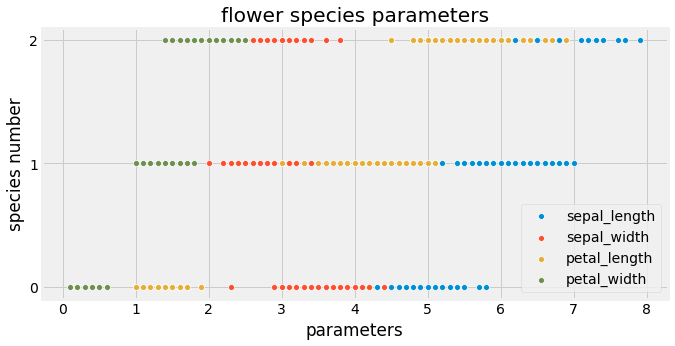

In [60]:
# Again, want a visual for the training columns.

plt.figure(figsize=(10, 5));

# plot all the values for each column:
sns.scatterplot(iris['sepal_length'], iris['species_num'], label='sepal_length');
sns.scatterplot(iris['sepal_width'], iris['species_num'], label='sepal_width');
sns.scatterplot(iris['petal_length'], iris['species_num'], label='petal_length');
sns.scatterplot(iris['petal_width'], iris['species_num'], label='petal_width');

plt.title('flower species parameters')
plt.xlabel('parameters');
plt.ylabel('species number');
plt.legend();

# Yep, you can see how separate the paramters are.  Just a tiny bit of mixing.

### Create a Model With Five Neighbors. Did it Improve?

In [183]:
# no.  1 neighbor was perfect, but I'll run on 5 anyway:

#instantiate
knn_5 = KNeighborsClassifier(5)

#fit
knn_5.fit(X_iris_train, y_iris_train)

#predict
iris_preds_5 = knn.predict(X_iris_test)

#score
iris_accuracy_5 = accuracy_score(iris_preds, y_iris_test)
iris_scored_5 = knn_5.score(X_iris_test, y_iris_test)

In [185]:
iris_accuracy
#iris_score
# no surprise here.  If 1 neighbor was perfect so should 5.

1.0

### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [198]:
# We know what this is going to result in:

scores_looped = []
neighbors = []

for n in range(1, 10):
    #instantiate
    knn_loop = KNeighborsRegressor(n)
    
    #fit
    knn_loop.fit(X_iris_train, y_iris_train)
    
    #predict
    knn_loop_preds = knn.predict(X_iris_test)
    
    #score
    score_looped = accuracy_score(iris_preds, y_iris_test)
    
    neighbors.append(n)
    scores_looped.append(score_looped)
    
for n, score_looped in zip(neighbors, scores_looped):
    print(n, 'neighbor has accuracy:', score_looped)
    
# As suspected all neighbors are a 1.

1 neighbor has accuracy: 1.0
2 neighbor has accuracy: 1.0
3 neighbor has accuracy: 1.0
4 neighbor has accuracy: 1.0
5 neighbor has accuracy: 1.0
6 neighbor has accuracy: 1.0
7 neighbor has accuracy: 1.0
8 neighbor has accuracy: 1.0
9 neighbor has accuracy: 1.0


### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

In [ ]:
# Return probability estimates for X_new data

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [ ]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

In [ ]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [ ]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [ ]:
# Check out Pearson scores


## Demo: Patsy

In [ ]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [ ]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [ ]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))